<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


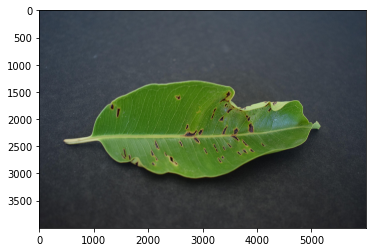

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

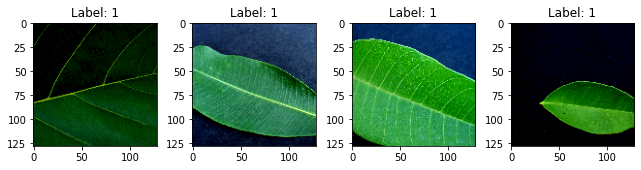

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:39] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:41] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2608451048020317 samples/sec                   batch loss = 0.2919095754623413 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2575550901279935 samples/sec                   batch loss = 0.3595373034477234 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.244183035307735 samples/sec                   batch loss = 0.5948022603988647 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2733558593310919 samples/sec                   batch loss = 1.2437853813171387 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.260947164536342 samples/sec                   batch loss = 0.3233773112297058 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.252636984547301 samples/sec                   batch loss = 0.9137693643569946 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2737427504001226 samples/sec                   batch loss = 0.6769410371780396 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.270929481631529 samples/sec                   batch loss = 0.7995345592498779 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2715511579970458 samples/sec                   batch loss = 0.5399146676063538 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.269606088158429 samples/sec                   batch loss = 0.5582007169723511 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2719222958504572 samples/sec                   batch loss = 0.41648879647254944 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.2730050377784061 samples/sec                   batch loss = 0.5702300667762756 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2715482668642062 samples/sec                   batch loss = 0.26341843605041504 | accuracy = 0.6192307692307693


Epoch[1] Batch[70] Speed: 1.271955082072533 samples/sec                   batch loss = 0.5013508200645447 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2755267229557719 samples/sec                   batch loss = 0.3402882516384125 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.2741978076059752 samples/sec                   batch loss = 1.6962429285049438 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.2725706194783704 samples/sec                   batch loss = 0.8621513247489929 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.263552093909399 samples/sec                   batch loss = 0.4791630506515503 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.2745159795976753 samples/sec                   batch loss = 0.3731703460216522 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2707341654109963 samples/sec                   batch loss = 0.470126211643219 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.27188690791345 samples/sec                   batch loss = 0.4363155663013458 | accuracy = 0.6238095238095238


Epoch[1] Batch[110] Speed: 1.2777023738897262 samples/sec                   batch loss = 0.6784951686859131 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2703907508687302 samples/sec                   batch loss = 0.523807168006897 | accuracy = 0.6260869565217392


Epoch[1] Batch[120] Speed: 1.2775664519039394 samples/sec                   batch loss = 1.5524450540542603 | accuracy = 0.6229166666666667


Epoch[1] Batch[125] Speed: 1.2757379692128097 samples/sec                   batch loss = 0.3798929452896118 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2703060082875857 samples/sec                   batch loss = 0.533894956111908 | accuracy = 0.625


Epoch[1] Batch[135] Speed: 1.2734043770026904 samples/sec                   batch loss = 0.6391297578811646 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2737846245234663 samples/sec                   batch loss = 0.7603462934494019 | accuracy = 0.6214285714285714


Epoch[1] Batch[145] Speed: 1.276326976504992 samples/sec                   batch loss = 0.4869289994239807 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.278442619834069 samples/sec                   batch loss = 0.5425599813461304 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.273632517605122 samples/sec                   batch loss = 0.6364331841468811 | accuracy = 0.6209677419354839


Epoch[1] Batch[160] Speed: 1.2726768068353023 samples/sec                   batch loss = 0.42086002230644226 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.27350703015866 samples/sec                   batch loss = 0.5385497808456421 | accuracy = 0.6242424242424243


Epoch[1] Batch[170] Speed: 1.275122272064283 samples/sec                   batch loss = 0.4590389132499695 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2628812682576092 samples/sec                   batch loss = 1.2125263214111328 | accuracy = 0.6242857142857143


Epoch[1] Batch[180] Speed: 1.2721487481169567 samples/sec                   batch loss = 0.5993298292160034 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2649697977929173 samples/sec                   batch loss = 0.7867875695228577 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.2643305276313366 samples/sec                   batch loss = 0.294350266456604 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2732715904108713 samples/sec                   batch loss = 0.2690907120704651 | accuracy = 0.632051282051282


Epoch[1] Batch[200] Speed: 1.2684915208667458 samples/sec                   batch loss = 0.38273394107818604 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.2619288044234107 samples/sec                   batch loss = 0.4575428366661072 | accuracy = 0.6390243902439025


Epoch[1] Batch[210] Speed: 1.2680131199916318 samples/sec                   batch loss = 0.17192606627941132 | accuracy = 0.6440476190476191


Epoch[1] Batch[215] Speed: 1.2683572637523175 samples/sec                   batch loss = 0.39638882875442505 | accuracy = 0.6453488372093024


Epoch[1] Batch[220] Speed: 1.2677132250021836 samples/sec                   batch loss = 1.2260338068008423 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2711183090805942 samples/sec                   batch loss = 0.6278947591781616 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.2733563425566043 samples/sec                   batch loss = 0.4987703859806061 | accuracy = 0.6510869565217391


Epoch[1] Batch[235] Speed: 1.2714862070494313 samples/sec                   batch loss = 0.11516430974006653 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.2745157859552099 samples/sec                   batch loss = 0.5689828991889954 | accuracy = 0.65


Epoch[1] Batch[245] Speed: 1.271000152954418 samples/sec                   batch loss = 1.7886077165603638 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2704830090514596 samples/sec                   batch loss = 0.8821269273757935 | accuracy = 0.651


Epoch[1] Batch[255] Speed: 1.2704174937803199 samples/sec                   batch loss = 1.5742664337158203 | accuracy = 0.6529411764705882


Epoch[1] Batch[260] Speed: 1.2766239669842827 samples/sec                   batch loss = 0.3061169683933258 | accuracy = 0.6538461538461539


Epoch[1] Batch[265] Speed: 1.2691300145195017 samples/sec                   batch loss = 1.1163289546966553 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.272816035652046 samples/sec                   batch loss = 0.4000469148159027 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.26940781680934 samples/sec                   batch loss = 1.0058271884918213 | accuracy = 0.6509090909090909


Epoch[1] Batch[280] Speed: 1.2741492294560797 samples/sec                   batch loss = 0.6161680817604065 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.270572297715256 samples/sec                   batch loss = 0.5827152729034424 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.264715194358223 samples/sec                   batch loss = 0.5114040374755859 | accuracy = 0.6508620689655172


Epoch[1] Batch[295] Speed: 1.2693271427100425 samples/sec                   batch loss = 0.35698121786117554 | accuracy = 0.6533898305084745


Epoch[1] Batch[300] Speed: 1.2690232663120375 samples/sec                   batch loss = 0.38647836446762085 | accuracy = 0.655


Epoch[1] Batch[305] Speed: 1.2673871424674532 samples/sec                   batch loss = 0.3329877257347107 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.2701589620155664 samples/sec                   batch loss = 0.427412748336792 | accuracy = 0.6588709677419354


Epoch[1] Batch[315] Speed: 1.2682969532009212 samples/sec                   batch loss = 0.4927203357219696 | accuracy = 0.6626984126984127


Epoch[1] Batch[320] Speed: 1.2718446763861428 samples/sec                   batch loss = 0.7449079751968384 | accuracy = 0.66484375


Epoch[1] Batch[325] Speed: 1.269103421784651 samples/sec                   batch loss = 1.5252962112426758 | accuracy = 0.6638461538461539


Epoch[1] Batch[330] Speed: 1.2695495975699906 samples/sec                   batch loss = 0.4375990927219391 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2678231061545797 samples/sec                   batch loss = 0.47986167669296265 | accuracy = 0.6671641791044776


Epoch[1] Batch[340] Speed: 1.262570398286653 samples/sec                   batch loss = 0.42876020073890686 | accuracy = 0.6676470588235294


Epoch[1] Batch[345] Speed: 1.262463230676837 samples/sec                   batch loss = 0.3983399271965027 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.2719153531026428 samples/sec                   batch loss = 0.9278815984725952 | accuracy = 0.6692857142857143


Epoch[1] Batch[355] Speed: 1.269263379011449 samples/sec                   batch loss = 0.6713345646858215 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2643512989936414 samples/sec                   batch loss = 0.7793751955032349 | accuracy = 0.6701388888888888


Epoch[1] Batch[365] Speed: 1.2693920653462547 samples/sec                   batch loss = 0.5206438899040222 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2679225616648546 samples/sec                   batch loss = 0.681126594543457 | accuracy = 0.6702702702702703


Epoch[1] Batch[375] Speed: 1.2708354258633836 samples/sec                   batch loss = 0.747938871383667 | accuracy = 0.67


Epoch[1] Batch[380] Speed: 1.2667606349290723 samples/sec                   batch loss = 0.5738577842712402 | accuracy = 0.6703947368421053


Epoch[1] Batch[385] Speed: 1.2705437201286536 samples/sec                   batch loss = 0.5181582570075989 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.268312677497798 samples/sec                   batch loss = 0.24135074019432068 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.2636727716407672 samples/sec                   batch loss = 0.5162551403045654 | accuracy = 0.6708860759493671


Epoch[1] Batch[400] Speed: 1.2669527222859076 samples/sec                   batch loss = 0.580880880355835 | accuracy = 0.671875


Epoch[1] Batch[405] Speed: 1.2695275022789834 samples/sec                   batch loss = 0.26281797885894775 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2695580516238927 samples/sec                   batch loss = 0.5267886519432068 | accuracy = 0.675609756097561


Epoch[1] Batch[415] Speed: 1.2744137445617636 samples/sec                   batch loss = 0.8142330646514893 | accuracy = 0.6753012048192771


Epoch[1] Batch[420] Speed: 1.2689654838571092 samples/sec                   batch loss = 1.1107090711593628 | accuracy = 0.6738095238095239


Epoch[1] Batch[425] Speed: 1.27312231105035 samples/sec                   batch loss = 0.5479398965835571 | accuracy = 0.6752941176470588


Epoch[1] Batch[430] Speed: 1.2674108867206708 samples/sec                   batch loss = 0.5090587735176086 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.268473682212912 samples/sec                   batch loss = 0.7090525031089783 | accuracy = 0.6770114942528735


Epoch[1] Batch[440] Speed: 1.2698894816023185 samples/sec                   batch loss = 0.3239421844482422 | accuracy = 0.6778409090909091


Epoch[1] Batch[445] Speed: 1.2662784730676067 samples/sec                   batch loss = 0.36770665645599365 | accuracy = 0.6780898876404494


Epoch[1] Batch[450] Speed: 1.2742761017025879 samples/sec                   batch loss = 0.3964730203151703 | accuracy = 0.6788888888888889


Epoch[1] Batch[455] Speed: 1.2786806581709973 samples/sec                   batch loss = 0.6718649864196777 | accuracy = 0.6774725274725275


Epoch[1] Batch[460] Speed: 1.2736615243855176 samples/sec                   batch loss = 0.3095338046550751 | accuracy = 0.6782608695652174


Epoch[1] Batch[465] Speed: 1.272040816388424 samples/sec                   batch loss = 0.6395507454872131 | accuracy = 0.678494623655914


Epoch[1] Batch[470] Speed: 1.275950741041233 samples/sec                   batch loss = 0.5440597534179688 | accuracy = 0.6797872340425531


Epoch[1] Batch[475] Speed: 1.2754752313759978 samples/sec                   batch loss = 0.41994261741638184 | accuracy = 0.6794736842105263


Epoch[1] Batch[480] Speed: 1.2685006322007202 samples/sec                   batch loss = 0.7000580430030823 | accuracy = 0.6791666666666667


Epoch[1] Batch[485] Speed: 1.2713921652120148 samples/sec                   batch loss = 0.4454323947429657 | accuracy = 0.6804123711340206


Epoch[1] Batch[490] Speed: 1.2737677004700587 samples/sec                   batch loss = 0.4180305004119873 | accuracy = 0.6811224489795918


Epoch[1] Batch[495] Speed: 1.2699101476526873 samples/sec                   batch loss = 1.1010117530822754 | accuracy = 0.6813131313131313


Epoch[1] Batch[500] Speed: 1.2744818994298823 samples/sec                   batch loss = 0.7079582810401917 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.2755408814446507 samples/sec                   batch loss = 0.4554832875728607 | accuracy = 0.6787128712871288


Epoch[1] Batch[510] Speed: 1.2649311715756728 samples/sec                   batch loss = 0.7586297392845154 | accuracy = 0.6794117647058824


Epoch[1] Batch[515] Speed: 1.2707221345857451 samples/sec                   batch loss = 0.7001416683197021 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.2666503640789617 samples/sec                   batch loss = 0.7786783576011658 | accuracy = 0.6793269230769231


Epoch[1] Batch[525] Speed: 1.2715780461621529 samples/sec                   batch loss = 0.47215259075164795 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.2700315622663243 samples/sec                   batch loss = 1.1250578165054321 | accuracy = 0.6768867924528302


Epoch[1] Batch[535] Speed: 1.2653519906429869 samples/sec                   batch loss = 0.3799769878387451 | accuracy = 0.6789719626168225


Epoch[1] Batch[540] Speed: 1.268838803203268 samples/sec                   batch loss = 0.3758283853530884 | accuracy = 0.6805555555555556


Epoch[1] Batch[545] Speed: 1.2704230733786526 samples/sec                   batch loss = 0.335471510887146 | accuracy = 0.6811926605504587


Epoch[1] Batch[550] Speed: 1.271586334499678 samples/sec                   batch loss = 1.0838176012039185 | accuracy = 0.6813636363636364


Epoch[1] Batch[555] Speed: 1.272355692590324 samples/sec                   batch loss = 0.9078092575073242 | accuracy = 0.6806306306306307


Epoch[1] Batch[560] Speed: 1.268944560611385 samples/sec                   batch loss = 0.16343115270137787 | accuracy = 0.6799107142857143


Epoch[1] Batch[565] Speed: 1.2761699906218649 samples/sec                   batch loss = 0.6899716258049011 | accuracy = 0.6800884955752212


Epoch[1] Batch[570] Speed: 1.267156352558132 samples/sec                   batch loss = 1.0219779014587402 | accuracy = 0.6798245614035088


Epoch[1] Batch[575] Speed: 1.270261765802392 samples/sec                   batch loss = 0.6688693761825562 | accuracy = 0.6791304347826087


Epoch[1] Batch[580] Speed: 1.2683541953504913 samples/sec                   batch loss = 0.555763840675354 | accuracy = 0.6788793103448276


Epoch[1] Batch[585] Speed: 1.2681514260794096 samples/sec                   batch loss = 0.9449713826179504 | accuracy = 0.6803418803418804


Epoch[1] Batch[590] Speed: 1.2650274076946033 samples/sec                   batch loss = 0.4367540180683136 | accuracy = 0.6809322033898305


Epoch[1] Batch[595] Speed: 1.2635740768579353 samples/sec                   batch loss = 0.8614681363105774 | accuracy = 0.6815126050420168


Epoch[1] Batch[600] Speed: 1.2672170332562958 samples/sec                   batch loss = 0.3359794616699219 | accuracy = 0.6820833333333334


Epoch[1] Batch[605] Speed: 1.2679517880709017 samples/sec                   batch loss = 0.3736143112182617 | accuracy = 0.6826446280991736


Epoch[1] Batch[610] Speed: 1.2670000834485944 samples/sec                   batch loss = 0.7118778228759766 | accuracy = 0.6807377049180328


Epoch[1] Batch[615] Speed: 1.2648266541841686 samples/sec                   batch loss = 0.42907464504241943 | accuracy = 0.6808943089430894


Epoch[1] Batch[620] Speed: 1.269428467185428 samples/sec                   batch loss = 0.9546812772750854 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.2700086810943811 samples/sec                   batch loss = 0.442461222410202 | accuracy = 0.6828


Epoch[1] Batch[630] Speed: 1.2625446497979367 samples/sec                   batch loss = 0.2040395736694336 | accuracy = 0.6841269841269841


Epoch[1] Batch[635] Speed: 1.2654113533323628 samples/sec                   batch loss = 0.39497819542884827 | accuracy = 0.6846456692913386


Epoch[1] Batch[640] Speed: 1.2638347901358427 samples/sec                   batch loss = 0.20120719075202942 | accuracy = 0.68515625


Epoch[1] Batch[645] Speed: 1.2691449914239068 samples/sec                   batch loss = 0.5572612285614014 | accuracy = 0.6864341085271318


Epoch[1] Batch[650] Speed: 1.2681541100718199 samples/sec                   batch loss = 0.32410329580307007 | accuracy = 0.6865384615384615


Epoch[1] Batch[655] Speed: 1.2687109965435122 samples/sec                   batch loss = 0.3847484886646271 | accuracy = 0.6866412213740458


Epoch[1] Batch[660] Speed: 1.2689713386503332 samples/sec                   batch loss = 0.530167818069458 | accuracy = 0.6863636363636364


Epoch[1] Batch[665] Speed: 1.268759736586576 samples/sec                   batch loss = 0.9839290976524353 | accuracy = 0.6864661654135338


Epoch[1] Batch[670] Speed: 1.2666158426333312 samples/sec                   batch loss = 0.31310078501701355 | accuracy = 0.685820895522388


Epoch[1] Batch[675] Speed: 1.2752204528832745 samples/sec                   batch loss = 0.5175953507423401 | accuracy = 0.6866666666666666


Epoch[1] Batch[680] Speed: 1.2766070645370322 samples/sec                   batch loss = 0.16247597336769104 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.267115391587012 samples/sec                   batch loss = 0.449001282453537 | accuracy = 0.6875912408759124


Epoch[1] Batch[690] Speed: 1.2686515157381237 samples/sec                   batch loss = 1.090771198272705 | accuracy = 0.6880434782608695


Epoch[1] Batch[695] Speed: 1.268740834983613 samples/sec                   batch loss = 0.5342992544174194 | accuracy = 0.6888489208633094


Epoch[1] Batch[700] Speed: 1.2674092590620067 samples/sec                   batch loss = 0.5085361003875732 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2675748229350647 samples/sec                   batch loss = 0.1663610190153122 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2728392112276674 samples/sec                   batch loss = 0.6658668518066406 | accuracy = 0.6901408450704225


Epoch[1] Batch[715] Speed: 1.2650135770243256 samples/sec                   batch loss = 0.6650398969650269 | accuracy = 0.6902097902097902


Epoch[1] Batch[720] Speed: 1.2628828843069797 samples/sec                   batch loss = 0.7011120319366455 | accuracy = 0.6909722222222222


Epoch[1] Batch[725] Speed: 1.2648303730285577 samples/sec                   batch loss = 0.7245128750801086 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.2627580804337262 samples/sec                   batch loss = 1.4335029125213623 | accuracy = 0.6907534246575342


Epoch[1] Batch[735] Speed: 1.2654804577545264 samples/sec                   batch loss = 0.511025607585907 | accuracy = 0.6908163265306122


Epoch[1] Batch[740] Speed: 1.2656187847183535 samples/sec                   batch loss = 0.5684346556663513 | accuracy = 0.691554054054054


Epoch[1] Batch[745] Speed: 1.2595578428557217 samples/sec                   batch loss = 0.35850268602371216 | accuracy = 0.6922818791946309


Epoch[1] Batch[750] Speed: 1.26115939174668 samples/sec                   batch loss = 0.595813512802124 | accuracy = 0.6923333333333334


Epoch[1] Batch[755] Speed: 1.269484850936007 samples/sec                   batch loss = 0.7351535558700562 | accuracy = 0.6917218543046357


Epoch[1] Batch[760] Speed: 1.264417333591685 samples/sec                   batch loss = 0.28585588932037354 | accuracy = 0.6934210526315789


Epoch[1] Batch[765] Speed: 1.2586706262602863 samples/sec                   batch loss = 0.22999411821365356 | accuracy = 0.6944444444444444


Epoch[1] Batch[770] Speed: 1.2579926154527223 samples/sec                   batch loss = 0.6943076848983765 | accuracy = 0.6954545454545454


Epoch[1] Batch[775] Speed: 1.2634479945760622 samples/sec                   batch loss = 0.7018407583236694 | accuracy = 0.6951612903225807


Epoch[1] Batch[780] Speed: 1.2632986315332055 samples/sec                   batch loss = 0.38368579745292664 | accuracy = 0.6951923076923077


Epoch[1] Batch[785] Speed: 1.2631237218913982 samples/sec                   batch loss = 0.15900856256484985 | accuracy = 0.6961783439490445


[Epoch 1] training: accuracy=0.6970177664974619
[Epoch 1] time cost: 647.9463412761688
[Epoch 1] validation: validation accuracy=0.6988888888888889


Epoch[2] Batch[5] Speed: 1.2723384205233272 samples/sec                   batch loss = 0.4267188310623169 | accuracy = 0.95


Epoch[2] Batch[10] Speed: 1.2647517098277639 samples/sec                   batch loss = 0.4132429361343384 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2684082781078438 samples/sec                   batch loss = 0.2879056930541992 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2705018663876653 samples/sec                   batch loss = 0.514916181564331 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2692675080931122 samples/sec                   batch loss = 0.1884089857339859 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.2643472971184677 samples/sec                   batch loss = 0.48064109683036804 | accuracy = 0.8


Epoch[2] Batch[35] Speed: 1.2751056031798111 samples/sec                   batch loss = 0.5464099645614624 | accuracy = 0.7928571428571428


Epoch[2] Batch[40] Speed: 1.272024999514761 samples/sec                   batch loss = 0.4294801950454712 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2744615683796003 samples/sec                   batch loss = 0.48488467931747437 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.27507924397294 samples/sec                   batch loss = 0.8607357144355774 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2693491349894608 samples/sec                   batch loss = 0.8137827515602112 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2706512054709778 samples/sec                   batch loss = 0.7068764567375183 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2756354410560913 samples/sec                   batch loss = 0.645169734954834 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2744541138236876 samples/sec                   batch loss = 0.7360368967056274 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2726608776020487 samples/sec                   batch loss = 0.08129015564918518 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2735203704843725 samples/sec                   batch loss = 1.2560627460479736 | accuracy = 0.7625


Epoch[2] Batch[85] Speed: 1.267241441169657 samples/sec                   batch loss = 0.31601089239120483 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2755702661609563 samples/sec                   batch loss = 0.24934956431388855 | accuracy = 0.7583333333333333


Epoch[2] Batch[95] Speed: 1.2761626131384562 samples/sec                   batch loss = 0.29240846633911133 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2713666337127505 samples/sec                   batch loss = 0.7776767611503601 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.27181102815846 samples/sec                   batch loss = 0.2341616004705429 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.2678171661458408 samples/sec                   batch loss = 0.5631589293479919 | accuracy = 0.7613636363636364


Epoch[2] Batch[115] Speed: 1.2673829298702908 samples/sec                   batch loss = 0.8049545288085938 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.2737011691222129 samples/sec                   batch loss = 0.5593515634536743 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2746117430062687 samples/sec                   batch loss = 0.5723158717155457 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.2726646426575583 samples/sec                   batch loss = 0.520755410194397 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2709929314096893 samples/sec                   batch loss = 0.41148313879966736 | accuracy = 0.7407407407407407


Epoch[2] Batch[140] Speed: 1.2738329814399525 samples/sec                   batch loss = 0.5662387609481812 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2731904244745682 samples/sec                   batch loss = 0.19679202139377594 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2744464657335786 samples/sec                   batch loss = 0.46909528970718384 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.2685265282856149 samples/sec                   batch loss = 0.284248948097229 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2705836521300802 samples/sec                   batch loss = 0.22446094453334808 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.263950665499842 samples/sec                   batch loss = 0.4794333875179291 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2749332220811305 samples/sec                   batch loss = 0.28866538405418396 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.2717891433040864 samples/sec                   batch loss = 0.37144801020622253 | accuracy = 0.7457142857142857


Epoch[2] Batch[180] Speed: 1.267896211142319 samples/sec                   batch loss = 0.21572794020175934 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.2687601203813021 samples/sec                   batch loss = 0.3324377238750458 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.2691180140499094 samples/sec                   batch loss = 0.2046501487493515 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.271303242952265 samples/sec                   batch loss = 0.820361852645874 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.272321824342069 samples/sec                   batch loss = 0.448142945766449 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2678256929499763 samples/sec                   batch loss = 0.0732608437538147 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.2701710783414506 samples/sec                   batch loss = 0.6832714080810547 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.268251028980792 samples/sec                   batch loss = 0.5740694403648376 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2705168756879952 samples/sec                   batch loss = 0.582883358001709 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2725439788859174 samples/sec                   batch loss = 0.8164830803871155 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.269049855687811 samples/sec                   batch loss = 0.35406723618507385 | accuracy = 0.7456521739130435


Epoch[2] Batch[235] Speed: 1.2675950306260375 samples/sec                   batch loss = 0.3916432857513428 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.270132614612719 samples/sec                   batch loss = 0.29011431336402893 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2744940983714155 samples/sec                   batch loss = 0.34483781456947327 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2682847767266956 samples/sec                   batch loss = 0.7890533208847046 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.271957685756729 samples/sec                   batch loss = 0.8664723038673401 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.2712061459605002 samples/sec                   batch loss = 0.49665918946266174 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2715898040683984 samples/sec                   batch loss = 0.23636338114738464 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.270365548148067 samples/sec                   batch loss = 0.7370872497558594 | accuracy = 0.7472222222222222


Epoch[2] Batch[275] Speed: 1.2688549247908538 samples/sec                   batch loss = 0.8925939798355103 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.2685342973172626 samples/sec                   batch loss = 0.3517419695854187 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.2683911130451784 samples/sec                   batch loss = 0.4470043182373047 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.2696186743314515 samples/sec                   batch loss = 0.3292599022388458 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.262436536611618 samples/sec                   batch loss = 0.5435301661491394 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2778564278199405 samples/sec                   batch loss = 0.6208756566047668 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.2747427753095906 samples/sec                   batch loss = 1.1457961797714233 | accuracy = 0.75


Epoch[2] Batch[310] Speed: 1.2717287951409777 samples/sec                   batch loss = 0.7555863261222839 | accuracy = 0.7475806451612903


Epoch[2] Batch[315] Speed: 1.2672254562730894 samples/sec                   batch loss = 0.15310513973236084 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.2687849715841049 samples/sec                   batch loss = 0.6509808897972107 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2665429808286952 samples/sec                   batch loss = 0.25268277525901794 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.2672983966241667 samples/sec                   batch loss = 0.1108451783657074 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.2712764627371593 samples/sec                   batch loss = 0.47772473096847534 | accuracy = 0.7514925373134328


Epoch[2] Batch[340] Speed: 1.2720113047345627 samples/sec                   batch loss = 0.8869317173957825 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.2684437604363445 samples/sec                   batch loss = 0.3048158586025238 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2630588683102106 samples/sec                   batch loss = 0.3020467460155487 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.2729570334542033 samples/sec                   batch loss = 0.46813008189201355 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2737801758715719 samples/sec                   batch loss = 0.3271018862724304 | accuracy = 0.7506944444444444


Epoch[2] Batch[365] Speed: 1.2628793670283507 samples/sec                   batch loss = 0.41481107473373413 | accuracy = 0.7520547945205479


Epoch[2] Batch[370] Speed: 1.2648672765926874 samples/sec                   batch loss = 0.41959115862846375 | accuracy = 0.7520270270270271


Epoch[2] Batch[375] Speed: 1.2657241969899282 samples/sec                   batch loss = 0.40258702635765076 | accuracy = 0.7533333333333333


Epoch[2] Batch[380] Speed: 1.2688617382039995 samples/sec                   batch loss = 0.4286614656448364 | accuracy = 0.7532894736842105


Epoch[2] Batch[385] Speed: 1.274114975378085 samples/sec                   batch loss = 1.3842558860778809 | accuracy = 0.7512987012987012


Epoch[2] Batch[390] Speed: 1.2725659862517311 samples/sec                   batch loss = 0.42422202229499817 | accuracy = 0.75


Epoch[2] Batch[395] Speed: 1.2733107276850177 samples/sec                   batch loss = 0.38268351554870605 | accuracy = 0.75


Epoch[2] Batch[400] Speed: 1.2712860957781296 samples/sec                   batch loss = 0.2489984631538391 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2761846487696313 samples/sec                   batch loss = 1.0243902206420898 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.2713113350377896 samples/sec                   batch loss = 0.28732940554618835 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.2725567198996652 samples/sec                   batch loss = 0.31314966082572937 | accuracy = 0.7493975903614458


Epoch[2] Batch[420] Speed: 1.2680770456671921 samples/sec                   batch loss = 0.48029083013534546 | accuracy = 0.7482142857142857


Epoch[2] Batch[425] Speed: 1.2676586268057122 samples/sec                   batch loss = 0.4928050637245178 | accuracy = 0.7482352941176471


Epoch[2] Batch[430] Speed: 1.271779213420331 samples/sec                   batch loss = 0.8033356070518494 | accuracy = 0.7465116279069768


Epoch[2] Batch[435] Speed: 1.2683828663087842 samples/sec                   batch loss = 0.3285953998565674 | accuracy = 0.746551724137931


Epoch[2] Batch[440] Speed: 1.269631068593022 samples/sec                   batch loss = 0.5864450335502625 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.2708822113323328 samples/sec                   batch loss = 0.22957345843315125 | accuracy = 0.7455056179775281


Epoch[2] Batch[450] Speed: 1.267855777197601 samples/sec                   batch loss = 0.3629928529262543 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2681969596319895 samples/sec                   batch loss = 0.9857797622680664 | accuracy = 0.7450549450549451


Epoch[2] Batch[460] Speed: 1.2671273542136898 samples/sec                   batch loss = 0.556584358215332 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.2697039017785388 samples/sec                   batch loss = 0.5131781697273254 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.2671110850967011 samples/sec                   batch loss = 0.2976943850517273 | accuracy = 0.7489361702127659


Epoch[2] Batch[475] Speed: 1.2736340646000561 samples/sec                   batch loss = 0.4446655809879303 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2691532480736383 samples/sec                   batch loss = 1.4268497228622437 | accuracy = 0.7484375


Epoch[2] Batch[485] Speed: 1.2711705089208094 samples/sec                   batch loss = 0.6497048139572144 | accuracy = 0.75


Epoch[2] Batch[490] Speed: 1.2679824532896151 samples/sec                   batch loss = 0.7826259136199951 | accuracy = 0.75


Epoch[2] Batch[495] Speed: 1.2707146274662147 samples/sec                   batch loss = 0.3494284749031067 | accuracy = 0.7515151515151515


Epoch[2] Batch[500] Speed: 1.26661335639687 samples/sec                   batch loss = 0.2985958456993103 | accuracy = 0.7535


Epoch[2] Batch[505] Speed: 1.272768238692597 samples/sec                   batch loss = 0.27959468960762024 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.2672041118004513 samples/sec                   batch loss = 0.20665274560451508 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.270732914194556 samples/sec                   batch loss = 0.29650601744651794 | accuracy = 0.7558252427184466


Epoch[2] Batch[520] Speed: 1.2640513238764897 samples/sec                   batch loss = 0.3567512035369873 | accuracy = 0.7557692307692307


Epoch[2] Batch[525] Speed: 1.2648308498050609 samples/sec                   batch loss = 0.2627321183681488 | accuracy = 0.7533333333333333


Epoch[2] Batch[530] Speed: 1.2655008850924603 samples/sec                   batch loss = 0.5069186687469482 | accuracy = 0.7518867924528302


Epoch[2] Batch[535] Speed: 1.267270349012653 samples/sec                   batch loss = 0.3001669645309448 | accuracy = 0.7532710280373832


Epoch[2] Batch[540] Speed: 1.267106874334479 samples/sec                   batch loss = 1.031834363937378 | accuracy = 0.7541666666666667


Epoch[2] Batch[545] Speed: 1.2693441410425421 samples/sec                   batch loss = 0.41328227519989014 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.2736910159667492 samples/sec                   batch loss = 0.20702126622200012 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.2702134873024955 samples/sec                   batch loss = 1.5898441076278687 | accuracy = 0.754054054054054


Epoch[2] Batch[560] Speed: 1.2651441696811203 samples/sec                   batch loss = 0.26652294397354126 | accuracy = 0.7540178571428572


Epoch[2] Batch[565] Speed: 1.2658717463659377 samples/sec                   batch loss = 0.36143431067466736 | accuracy = 0.7548672566371681


Epoch[2] Batch[570] Speed: 1.2684202651589467 samples/sec                   batch loss = 0.9092373847961426 | accuracy = 0.7552631578947369


Epoch[2] Batch[575] Speed: 1.265206375224747 samples/sec                   batch loss = 0.41234642267227173 | accuracy = 0.7556521739130435


Epoch[2] Batch[580] Speed: 1.2695209699054686 samples/sec                   batch loss = 0.5649471879005432 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.2721182668811681 samples/sec                   batch loss = 0.23754282295703888 | accuracy = 0.7564102564102564


Epoch[2] Batch[590] Speed: 1.2711141679484093 samples/sec                   batch loss = 0.4436950385570526 | accuracy = 0.7555084745762712


Epoch[2] Batch[595] Speed: 1.268236073167745 samples/sec                   batch loss = 0.5316603779792786 | accuracy = 0.7546218487394958


Epoch[2] Batch[600] Speed: 1.2604275616956961 samples/sec                   batch loss = 0.7291507124900818 | accuracy = 0.7545833333333334


Epoch[2] Batch[605] Speed: 1.2651818548245701 samples/sec                   batch loss = 0.36515694856643677 | accuracy = 0.7549586776859504


Epoch[2] Batch[610] Speed: 1.2650197769425686 samples/sec                   batch loss = 0.3228973150253296 | accuracy = 0.7557377049180328


Epoch[2] Batch[615] Speed: 1.270756976481111 samples/sec                   batch loss = 0.18249958753585815 | accuracy = 0.7569105691056911


Epoch[2] Batch[620] Speed: 1.2639615209773325 samples/sec                   batch loss = 0.35855379700660706 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.2681843057693063 samples/sec                   batch loss = 0.6547458171844482 | accuracy = 0.758


Epoch[2] Batch[630] Speed: 1.2640495143601922 samples/sec                   batch loss = 0.42420756816864014 | accuracy = 0.7575396825396825


Epoch[2] Batch[635] Speed: 1.2730027195789502 samples/sec                   batch loss = 0.22926998138427734 | accuracy = 0.7570866141732283


Epoch[2] Batch[640] Speed: 1.266730793914455 samples/sec                   batch loss = 0.5130631923675537 | accuracy = 0.75703125


Epoch[2] Batch[645] Speed: 1.2701101144113967 samples/sec                   batch loss = 1.0741075277328491 | accuracy = 0.7569767441860465


Epoch[2] Batch[650] Speed: 1.2709566323544863 samples/sec                   batch loss = 0.49024778604507446 | accuracy = 0.7565384615384615


Epoch[2] Batch[655] Speed: 1.2712658665607053 samples/sec                   batch loss = 0.6390646696090698 | accuracy = 0.7572519083969466


Epoch[2] Batch[660] Speed: 1.2747978885904665 samples/sec                   batch loss = 0.2786521911621094 | accuracy = 0.7571969696969697


Epoch[2] Batch[665] Speed: 1.2749738180425965 samples/sec                   batch loss = 0.9526926279067993 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.2759049401076927 samples/sec                   batch loss = 0.5348272919654846 | accuracy = 0.7555970149253731


Epoch[2] Batch[675] Speed: 1.2764214584857958 samples/sec                   batch loss = 0.4294120669364929 | accuracy = 0.7566666666666667


Epoch[2] Batch[680] Speed: 1.2720231670975053 samples/sec                   batch loss = 0.47755300998687744 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2754489538480742 samples/sec                   batch loss = 0.24062925577163696 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.2752876277409075 samples/sec                   batch loss = 0.49780744314193726 | accuracy = 0.7557971014492754


Epoch[2] Batch[695] Speed: 1.2728726241679718 samples/sec                   batch loss = 1.2958024740219116 | accuracy = 0.7557553956834533


Epoch[2] Batch[700] Speed: 1.2749245994054887 samples/sec                   batch loss = 0.49429142475128174 | accuracy = 0.7564285714285715


Epoch[2] Batch[705] Speed: 1.2745439615525245 samples/sec                   batch loss = 0.6757052540779114 | accuracy = 0.7556737588652482


Epoch[2] Batch[710] Speed: 1.270365067189839 samples/sec                   batch loss = 0.37423980236053467 | accuracy = 0.7563380281690141


Epoch[2] Batch[715] Speed: 1.281129902776802 samples/sec                   batch loss = 0.22290624678134918 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.2742588742401597 samples/sec                   batch loss = 0.5815227031707764 | accuracy = 0.7576388888888889


Epoch[2] Batch[725] Speed: 1.2702163723687092 samples/sec                   batch loss = 0.3847923278808594 | accuracy = 0.7582758620689655


Epoch[2] Batch[730] Speed: 1.2715031668941428 samples/sec                   batch loss = 0.8062483668327332 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2732171887647485 samples/sec                   batch loss = 0.32176461815834045 | accuracy = 0.7585034013605442


Epoch[2] Batch[740] Speed: 1.2773190061052733 samples/sec                   batch loss = 0.20530292391777039 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.2774867802341372 samples/sec                   batch loss = 0.25508224964141846 | accuracy = 0.7590604026845638


Epoch[2] Batch[750] Speed: 1.2700246401441315 samples/sec                   batch loss = 0.08934944868087769 | accuracy = 0.7593333333333333


Epoch[2] Batch[755] Speed: 1.2750202304354514 samples/sec                   batch loss = 0.34768325090408325 | accuracy = 0.7596026490066226


Epoch[2] Batch[760] Speed: 1.2723733511100797 samples/sec                   batch loss = 0.5881059765815735 | accuracy = 0.7605263157894737


Epoch[2] Batch[765] Speed: 1.2749230492739219 samples/sec                   batch loss = 1.1916710138320923 | accuracy = 0.7607843137254902


Epoch[2] Batch[770] Speed: 1.2690742382607985 samples/sec                   batch loss = 0.38420817255973816 | accuracy = 0.7610389610389611


Epoch[2] Batch[775] Speed: 1.2684699419136403 samples/sec                   batch loss = 0.2580070197582245 | accuracy = 0.7616129032258064


Epoch[2] Batch[780] Speed: 1.2656960280424596 samples/sec                   batch loss = 0.6806610226631165 | accuracy = 0.7618589743589743


Epoch[2] Batch[785] Speed: 1.2684497063180185 samples/sec                   batch loss = 0.32746362686157227 | accuracy = 0.7621019108280255


[Epoch 2] training: accuracy=0.7623730964467005
[Epoch 2] time cost: 638.2646923065186
[Epoch 2] validation: validation accuracy=0.7711111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7644444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)